In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib tk

In [55]:

df = pd.read_parquet("../data/03_primary/train_data.parquet")

df.head()

data = df.copy()

In [56]:

data.info()
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 11787 entries, 2683 to 7385
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gradyear         11787 non-null  int64 
 1   gender           10878 non-null  object
 2   age              10007 non-null  object
 3   NumberOffriends  11787 non-null  int64 
 4   basketball       11787 non-null  int64 
 5   football         11787 non-null  int64 
 6   soccer           11787 non-null  int64 
 7   softball         11787 non-null  int64 
 8   volleyball       11787 non-null  int64 
 9   swimming         11787 non-null  int64 
 10  cheerleading     11787 non-null  int64 
 11  baseball         11787 non-null  int64 
 12  tennis           11787 non-null  int64 
 13  sports           11787 non-null  int64 
 14  cute             11787 non-null  int64 
 15  sex              11787 non-null  int64 
 16  sexy             11787 non-null  int64 
 17  hot              11787 non-null  i

0

In [57]:
# Limpieza general de dataset

data['age'] = data['age'].astype(str)


def clean_age(x: str) -> str:
    # Si el valor contiene solo letras, o espacios, o guiones, lo reemplaza por '0.00'
    if x.isalpha() or ' ' in x or '-' in x:
        return '0.00'
    return x

data['age'] = data['age'].apply(clean_age).astype('float32')

In [58]:

data['gender'] = data['gender'].map({'F': 0, 'M': 1})

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11787 entries, 2683 to 7385
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gradyear         11787 non-null  int64  
 1   gender           10878 non-null  float64
 2   age              11787 non-null  float32
 3   NumberOffriends  11787 non-null  int64  
 4   basketball       11787 non-null  int64  
 5   football         11787 non-null  int64  
 6   soccer           11787 non-null  int64  
 7   softball         11787 non-null  int64  
 8   volleyball       11787 non-null  int64  
 9   swimming         11787 non-null  int64  
 10  cheerleading     11787 non-null  int64  
 11  baseball         11787 non-null  int64  
 12  tennis           11787 non-null  int64  
 13  sports           11787 non-null  int64  
 14  cute             11787 non-null  int64  
 15  sex              11787 non-null  int64  
 16  sexy             11787 non-null  int64  
 17  hot            

In [60]:
# PARTICIÓN DE DATOS
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensiones del conjunto de entrenamiento:", train_data.shape)
print("Dimensiones del conjunto de prueba:", test_data.shape)

Dimensiones del conjunto de entrenamiento: (9429, 40)
Dimensiones del conjunto de prueba: (2358, 40)


In [61]:
def fit_imputar_genero_ponderado(df: pd.DataFrame, column: str) -> pd.DataFrame:
    probabilidades = df[column].value_counts(normalize=True)
    probabilidades_dict = probabilidades.to_dict()
    return probabilidades_dict

In [62]:
def transform_imputar_genero_ponderado(df, col, freq_dict):
    """
    Imputa los valores nulos de la columna 'col' 
    usando la distribución dada en 'freq_dict' (por ejemplo {0:0.3, 1:0.7}).
    """
    mask_null = df[col].isnull()

    if mask_null.any():
        possible_values = list(freq_dict.keys())
        probabilities = [freq_dict[val] for val in possible_values]   
        n_nulls = mask_null.sum()
        random_choices = np.random.choice(possible_values, size=n_nulls, p=probabilities)  
        df.loc[mask_null, col] = random_choices
    return df

In [63]:
# IMPUTACIÓN DE GÉNERO
probabilidades_genero_train = fit_imputar_genero_ponderado(train_data, 'gender')

train_data = transform_imputar_genero_ponderado(train_data, 'gender', probabilidades_genero_train)


test_data = transform_imputar_genero_ponderado(test_data, 'gender', probabilidades_genero_train)

In [64]:
probabilidades_genero_train

{0.0: 0.8095238095238095, 1.0: 0.19047619047619047}

In [65]:
def fit_outlier_mzscore(df: pd.DataFrame, col: str, threshold: float = 3.5) -> dict:
    """Calcula median y MAD de la columna para usar en z-score modificado."""
    data = df[col].dropna().values
    median_val = np.median(data)
    mad_val = np.median(np.abs(data - median_val))
    if mad_val == 0:
        mad_val = 1e-9
    return {"median": median_val, "mad": mad_val, "threshold": threshold}

In [66]:
params_mzscore_age_train = fit_outlier_mzscore(train_data, 'age')

In [67]:
params_mzscore_age_train

{'median': 16.862, 'mad': 1.2229996, 'threshold': 3.5}

In [68]:
def transform_outlier_mzscore(df: pd.DataFrame, col: str, params: dict) -> pd.DataFrame:
    """Reemplaza outliers con la median calculada en fit_outlier_mzscore."""
    df = df.copy()
    data = df[col].values
    z_score = 0.6745 * (data - params["median"]) / params["mad"]
    outliers_mask = np.abs(z_score) > params["threshold"]
    df.loc[outliers_mask, col] = params["median"]
    return df


train_data = transform_outlier_mzscore(train_data, col="age", params=params_mzscore_age_train)
test_data = transform_outlier_mzscore(test_data, col="age", params=params_mzscore_age_train)

(array([7636.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1793.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

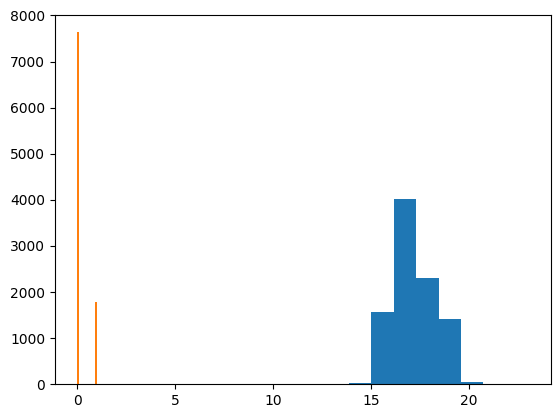

In [69]:
plt.hist(train_data['age'])

plt.hist(train_data['gender'])

In [70]:
def fit_feature_engineering(df: pd.DataFrame) -> dict:
    # Calcula parámetros para outliers en "age"
    params_age = fit_outlier_mzscore(df, "age")
    # Calcula la distribución de "gender" para imputar valores nulos
    params_gender = fit_imputar_genero_ponderado(df, "gender")
    return {"age": params_age, "gender": params_gender}

In [71]:
params = fit_feature_engineering(train_data)

In [72]:
params

{'age': {'median': 16.862, 'mad': 0.7370014, 'threshold': 3.5},
 'gender': {0.0: 0.8098419768798388, 1.0: 0.1901580231201612}}

In [73]:
import pickle

with open('../data/04_feature/fe_params.pkl', 'wb') as archivo:
    pickle.dump(params, archivo)

In [74]:
def transform_feature_engineering(df: pd.DataFrame, params: dict) -> pd.DataFrame:
    df = transform_outlier_mzscore(df, params=params["age"])
    df = transform_imputar_genero_ponderado(df, distrib=params["gender"])
    return df

In [75]:

# from sklearn.preprocessing import PowerTransformer

cols_to_transform = train_data.columns[3:]

# power_transformer = PowerTransformer(method='yeo-johnson')


#power_transformer.fit(train_data[cols_to_transform])

#train_data[cols_to_transform] = power_transformer.transform(train_data[cols_to_transform])

#test_data[cols_to_transform] = power_transformer.transform(test_data[cols_to_transform])



import numpy as np
from scipy import stats



for column in data.columns:
    stat, p_value = stats.shapiro(data[column])
    print(column)
    print("Estadístico de Shapiro-Wilk:", stat)
    print("p-valor:", p_value)

    if p_value > 0.05:
        print("No se rechaza la hipótesis nula: los datos parecen normales.")
    else:
        print("Se rechaza la hipótesis nula: los datos no parecen normales.")



# Luego del análisis de Yeo-Johnson, se descarta la opción de normalización de variables. En ninún caso se logra normalizar según Shapiro-Wilk.

gradyear
Estadístico de Shapiro-Wilk: 0.8574994802474976
p-valor: 0.0
Se rechaza la hipótesis nula: los datos no parecen normales.
gender
Estadístico de Shapiro-Wilk: nan
p-valor: 1.0
No se rechaza la hipótesis nula: los datos parecen normales.
age
Estadístico de Shapiro-Wilk: 0.4821549654006958
p-valor: 0.0
Se rechaza la hipótesis nula: los datos no parecen normales.
NumberOffriends
Estadístico de Shapiro-Wilk: 0.7698563933372498
p-valor: 0.0
Se rechaza la hipótesis nula: los datos no parecen normales.
basketball
Estadístico de Shapiro-Wilk: 0.3779177665710449
p-valor: 0.0
Se rechaza la hipótesis nula: los datos no parecen normales.
football
Estadístico de Shapiro-Wilk: 0.4153655767440796
p-valor: 0.0
Se rechaza la hipótesis nula: los datos no parecen normales.
soccer
Estadístico de Shapiro-Wilk: 0.26052820682525635
p-valor: 0.0
Se rechaza la hipótesis nula: los datos no parecen normales.
softball
Estadístico de Shapiro-Wilk: 0.22120487689971924
p-valor: 0.0
Se rechaza la hipótesis nu

/home/jsforerobiomed/miniconda3/envs/students_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [76]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cols_standard = ['age']  # variables que ya tienen distribución normal
cols_minmax = train_data.columns[3: ]            # variables que necesitan normalizarse al rango [0, 1]

scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

scaler_standard.fit(train_data[cols_standard])
scaler_minmax.fit(train_data[cols_minmax])


MinMaxScaler()

In [82]:
def fit_scalers(df: pd.DataFrame) -> dict:
    cols_standard = df.columns[2] # 'age' está en la posición 2
    cols_minmax = df.columns[3: ] # Todas las columnas a partir de la posición 3
    scaler_standard = StandardScaler()
    scaler_minmax = MinMaxScaler()
    standard_scaler_values = scaler_standard.fit(df[[cols_standard]])
    minmax_scaler_values = scaler_minmax.fit(df[cols_minmax]) 
    return {"standard": scaler_standard, "minmax": scaler_minmax}

In [83]:
scaler_params = fit_scalers(train_data)

In [89]:
scaler_params['standard'].scale_

array([1.08613894])

In [90]:
with open('../data/04_feature/scalers_params.pkl', 'wb') as archivo:
    pickle.dump(scaler_params, archivo)

In [52]:
train_data[cols_standard] = scaler_standard.transform(train_data[cols_standard])
train_data[cols_minmax] = scaler_minmax.transform(train_data[cols_minmax])


test_data[cols_standard] = scaler_standard.transform(test_data[cols_standard])
test_data[cols_minmax] = scaler_minmax.transform(test_data[cols_minmax])

print(train_data.head())

       gradyear  gender       age  NumberOffriends  basketball  football  \
4206       2008     0.0 -0.997379         0.000000         0.0       0.0   
13416      2006     1.0  1.326449         0.085950         0.0       0.0   
2208       2008     0.0 -0.747871         0.054545         0.0       0.0   
6315       2009     1.0 -1.570050         0.021488         0.0       0.0   
2064       2008     0.0 -0.795747         0.003306         0.0       0.0   

         soccer  softball  volleyball  swimming  ...  blonde  mall  shopping  \
4206   0.000000       0.0         0.0       0.0  ...     0.0   0.0  0.000000   
13416  0.000000       0.0         0.0       0.0  ...     0.0   0.0  0.142857   
2208   0.000000       0.0         0.0       0.0  ...     0.0   0.0  0.000000   
6315   0.000000       0.0         0.0       0.0  ...     0.0   0.0  0.000000   
2064   0.045455       0.0         0.0       0.0  ...     0.0   0.0  0.142857   

       clothes  hollister  abercrombie       die     death  dr